In [ ]:
# import os
# import json
# from tqdm import tqdm

# def extract_valid_furniture_data(json_dir):
#     result = []

#     bar = tqdm(os.listdir(json_dir), desc="Processing JSON files", unit="file")

#     for filename in bar:
#         if not filename.endswith(".json"):
#             continue

#         file_path = os.path.join(json_dir, filename)
#         try:
#             with open(file_path, 'r') as f:
#                 data = json.load(f)
#         except Exception as e:
#             print(f"Failed to load {filename}: {e}")
#             continue

#         furniture_list = data.get("furniture", [])
#         for item in furniture_list:
#             if not item.get("valid", False):
#                 continue
#             if not all(k in item for k in ("category", "size", "jid")):
#                 continue
#             result.append({
#                 "category": item["category"],
#                 "size": item["size"],
#                 "jid": item["jid"]
#             })

#     return result

# # 사용 예시
# json_directory = "/home/eden/Documents/JNU/2025-1/AI-System/AI-System-Project/3D-FRONT"
# furniture_data = extract_valid_furniture_data(json_directory)

# # funiture_data 저장
# output_file = "furniture_data.json"
# with open(output_file, 'w') as f:
#     json.dump(furniture_data, f, indent=4)


In [2]:
import json
# funiture_data 로드
output_file = "furniture_data.json"
with open(output_file, 'r') as f:
    furniture_data = json.load(f)

print(f"총 {len(furniture_data)}개의 유효한 가구 데이터가 추출되었습니다.")

# 결과 예시 출력
for item in furniture_data[:5]:
    print(item)

총 5831개의 유효한 가구 데이터가 추출되었습니다.
{'category': 'Lighting', 'size': [0.4941799926757813, 0.3422480010986328, 1.2236100006103516], 'jid': '71ab8f57-0cf2-4efb-83bd-6d87258622a6'}
{'category': 'Cabinet/Shelf/Desk', 'size': [0.9, 0.6229999923706054, 0.5], 'jid': '02a64bc1-70d6-4da7-98c8-19038cfe95ec'}
{'category': 'Cabinet/Shelf/Desk', 'size': [0.9, 0.625, 2.291999969482422], 'jid': 'a7cccc53-423b-401c-883d-60b4ed424507'}
{'category': 'Lighting', 'size': [0.28629800796508786, 0.18640800476074218, 1.5544700622558594], 'jid': 'd214e531-662b-42c0-a180-846178536688'}
{'category': 'Lighting', 'size': [0.5009120178222656, 0.4108599853515625, 0.05069169998168945], 'jid': 'b09d1f89-8d93-4263-82d4-264c49bd7ce5'}


In [3]:
from collections import Counter

# category 개수 세기
category_counts = Counter(item["category"] for item in furniture_data)

# 출력
for category, count in category_counts.items():
    print(f"{category}: {count}")


Lighting: 1511
Cabinet/Shelf/Desk: 2020
Table: 926
Chair: 320
Sofa: 379
Bed: 439
Pier/Stool: 141
Others: 95


In [4]:
from collections import defaultdict

# 고유 카테고리 추출 및 인덱스 매핑
category_set = sorted(set(item["category"] for item in furniture_data))
category_to_idx = {cat: i for i, cat in enumerate(category_set)}

# 카테고리 인덱스 출력
print("고유 카테고리 인덱스:")
for category, idx in category_to_idx.items():
    print(f"{category}: {idx}")

# 클래스 인덱스 리스트 생성
class_indices = [category_to_idx[item["category"]] for item in furniture_data]

# 클래스 인덱스 원-핫 인코딩
import numpy as np
one_hot_indices = np.zeros((len(class_indices), len(category_set)), dtype=int)
for i, idx in enumerate(class_indices):
    one_hot_indices[i, idx] = 1
# 사이즈 리스트 추출
size_list = [item["size"] for item in furniture_data]

print(one_hot_indices[:5])


고유 카테고리 인덱스:
Bed: 0
Cabinet/Shelf/Desk: 1
Chair: 2
Lighting: 3
Others: 4
Pier/Stool: 5
Sofa: 6
Table: 7
[[0 0 0 1 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0]]


In [28]:
import numpy as np
size_np = np.array(size_list, dtype=np.float32)
print("max size:", size_np.max())
print("min size:", size_np.min())

normalized_size = (size_np - size_np.min()) / (size_np.max() - size_np.min())
# 정규화된 사이즈를 리스트로 변환
normalized_size_list = normalized_size.tolist()

max size: 5.52886
min size: 0.00321001


In [29]:
import os

latent_vectors = []
valid_class_indices = []
valid_sizes = []

def make_img_path(jid):
    return os.path.join("/home/eden/Data/JNU/AI-System/3D-FUTURE-model", f"{jid}/image.jpg")


In [30]:

img_paths = [make_img_path(item["jid"]) for item in furniture_data]
batch_size = 4
batch_img_paths = [img_paths[i:i + batch_size] for i in range(0, len(img_paths), batch_size)]



In [31]:
import h5py 
latent_vectors_file1 = "/home/eden/Documents/JNU/2025-1/AI-System/AI-System-Project/latent_vectors_1.h5"

with h5py.File(latent_vectors_file1, 'r') as f:
    latent_vectors1 = f['latent_vectors'][:]




In [34]:
from tqdm import tqdm

for i in range(len(latent_vectors1)):
    latent_vectors.append(latent_vectors1[i])
    valid_class_indices.append(one_hot_indices[i])
    valid_sizes.append(size_list[i])


In [36]:
import torch.nn as nn

class FurnitureSizeRegressor(nn.Module):
    def __init__(self, latent_dim, class_count, hidden_dims=[256, 64], output_dim=3):
        super(FurnitureSizeRegressor, self).__init__()

        self.latent_extractor = nn.Sequential(
            nn.Linear(latent_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),

            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU(),
        )

        self.size_estimate_layer = nn.Sequential(
            nn.Linear(hidden_dims[1]+class_count, output_dim),
            nn.Sigmoid()  # 0~1 범위로 정규화된 size 예측
        )

    def forward(self, latent_vec, class_onehot):
        # x = torch.cat([latent_vec, class_onehot], dim=1)
        latent_ext = self.latent_extractor(latent_vec)
        x = torch.cat([latent_ext, class_onehot], dim=1)
        return self.size_estimate_layer(x)

In [38]:
from torch.cuda.amp import autocast, GradScaler

def train_model(model, train_dataloader, test_dataloader, epochs=10, lr=1e-3):
    device = next(model.parameters()).device
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scaler = GradScaler()

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        train_bar = tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
        for latents, classes, sizes in train_bar:
            latents, classes, sizes = latents.to(device), classes.to(device), sizes.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(latents, classes)
                loss = criterion(outputs, sizes)
            train_bar.set_postfix(loss=loss.item())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


            total_loss += loss.item() * latents.size(0)
            wandb.log({"train_loss": loss.item()})


        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

        model.eval()
        test_bar = tqdm(test_dataloader, total=len(test_dataloader), desc="Testing", unit="batch")
        with torch.no_grad():
            total_test_loss = 0.0
            for latents, classes, sizes in test_bar:
                latents, classes, sizes = latents.to(device), classes.to(device), sizes.to(device)
                with autocast():
                    outputs = model(latents, classes)
                    loss = criterion(outputs, sizes)
                total_test_loss += loss.item()
            avg_test_loss = total_test_loss / len(test_dataloader)
            wandb.log({"test_loss": avg_test_loss})
            print(f"Test Loss: {avg_test_loss:.4f}")






In [39]:
print(len(latent_vectors))

2916


In [17]:
latent_dim = latent_vectors[0].shape[0]  # latent vector의 차원
class_count = len(category_set)

print(f"Latent dimension: {latent_dim}, Class count: {class_count}")

Latent dimension: 1048576, Class count: 8


In [18]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import numpy as np
import wandb

from sklearn.model_selection import KFold

class FurnitureDataset(Dataset):
    def __init__(self, latent_vectors, class_indices, sizes):
        self.latents = torch.from_numpy(np.array(latent_vectors)).float()
        self.classes = torch.from_numpy(np.array(class_indices)).int()
        self.sizes = torch.from_numpy(np.array(normalized_size)).float()

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        return self.latents[idx], self.classes[idx], self.sizes[idx]

# 예시
dataset = FurnitureDataset(latent_vectors, valid_class_indices, valid_sizes)

# KFold 설정
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"\nFold {fold+1}/{k}")
    print(f"Train indices: {len(train_idx)}, Val indices: {len(val_idx)}")

    train_subset = Subset(dataset, train_idx)
    val_subset = Subset(dataset, val_idx)

    train_dataloader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_dataloader = DataLoader(val_subset, batch_size=16, shuffle=False)
    wandb.init(project="ai-system", name=f"furniture_norm_size_regression_fold_{fold+1}", config={
        "latent_dim": latent_dim,
        "class_count": class_count,
        "batch_size": 16,
        "epochs": 10,
        "learning_rate": 1e-3,
        "fold": fold + 1
        })
    # 모델 초기화 및 학습
    latent_dim = latent_vectors[0].shape[0]  # latent vector의 차원
    class_count = len(category_set)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = FurnitureSizeRegressor(latent_dim, class_count).to(device)
    train_model(model, train_dataloader, val_dataloader, epochs=10, lr=1e-3)
    wandb.finish()

    # # 모델 저장
    # output_model_path = "furniture_size_regressor.pth"
    # torch.save(model.state_dict(), output_model_path


Fold 1/5
Train indices: 2332, Val indices: 584


wandb: Currently logged in as: edenkim9741 (edenkim9741-chonnam-national-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/tmp/ipykernel_665546/2106628770.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/146 [00:00<?, ?batch/s]/tmp/ipykernel_665546/2106628770.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 146/146 [00:12<00:00, 11.65batch/s, loss=0.0112] 


Epoch 1/10, Loss: 0.4528


Testing:   0%|          | 0/37 [00:00<?, ?batch/s]/tmp/ipykernel_665546/2106628770.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 37/37 [00:00<00:00, 47.53batch/s]


Test Loss: 0.0131


Epoch 2/10: 100%|██████████| 146/146 [00:11<00:00, 12.17batch/s, loss=0.0138] 


Epoch 2/10, Loss: 0.2061


Testing: 100%|██████████| 37/37 [00:00<00:00, 48.40batch/s]


Test Loss: 0.0121


Epoch 3/10: 100%|██████████| 146/146 [00:12<00:00, 12.15batch/s, loss=0.00901]


Epoch 3/10, Loss: 0.1821


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.28batch/s]


Test Loss: 0.0117


Epoch 4/10: 100%|██████████| 146/146 [00:12<00:00, 12.11batch/s, loss=0.0121] 


Epoch 4/10, Loss: 0.1585


Testing: 100%|██████████| 37/37 [00:00<00:00, 42.37batch/s]


Test Loss: 0.0117


Epoch 5/10: 100%|██████████| 146/146 [00:12<00:00, 11.45batch/s, loss=0.00569]


Epoch 5/10, Loss: 0.1340


Testing: 100%|██████████| 37/37 [00:00<00:00, 44.37batch/s]


Test Loss: 0.0116


Epoch 6/10: 100%|██████████| 146/146 [00:12<00:00, 12.04batch/s, loss=0.00607]


Epoch 6/10, Loss: 0.1104


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.48batch/s]


Test Loss: 0.0115


Epoch 7/10: 100%|██████████| 146/146 [00:12<00:00, 12.10batch/s, loss=0.0103] 


Epoch 7/10, Loss: 0.0884


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.88batch/s]


Test Loss: 0.0114


Epoch 8/10: 100%|██████████| 146/146 [00:12<00:00, 12.14batch/s, loss=0.0069] 


Epoch 8/10, Loss: 0.0714


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.47batch/s]


Test Loss: 0.0116


Epoch 9/10: 100%|██████████| 146/146 [00:12<00:00, 11.75batch/s, loss=0.00479]


Epoch 9/10, Loss: 0.0597


Testing: 100%|██████████| 37/37 [00:00<00:00, 43.04batch/s]


Test Loss: 0.0122


Epoch 10/10: 100%|██████████| 146/146 [00:12<00:00, 11.74batch/s, loss=0.00702]


Epoch 10/10, Loss: 0.0495


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.12batch/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Loss: 0.0118


test_loss,█▄▂▂▂▁▁▂▄▃
train_loss,█▂▂▃▂▂▂▁▁▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.01179
train_loss,0.00702



Fold 2/5
Train indices: 2333, Val indices: 583


/tmp/ipykernel_665546/2106628770.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/146 [00:00<?, ?batch/s]/tmp/ipykernel_665546/2106628770.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 146/146 [00:12<00:00, 12.06batch/s, loss=0.0186] 


Epoch 1/10, Loss: 0.3994


Testing:   0%|          | 0/37 [00:00<?, ?batch/s]/tmp/ipykernel_665546/2106628770.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 37/37 [00:00<00:00, 47.12batch/s]


Test Loss: 0.0136


Epoch 2/10: 100%|██████████| 146/146 [00:12<00:00, 12.06batch/s, loss=0.0129] 


Epoch 2/10, Loss: 0.1993


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.70batch/s]


Test Loss: 0.0129


Epoch 3/10: 100%|██████████| 146/146 [00:12<00:00, 12.04batch/s, loss=0.0104] 


Epoch 3/10, Loss: 0.1807


Testing: 100%|██████████| 37/37 [00:00<00:00, 45.77batch/s]


Test Loss: 0.0120


Epoch 4/10: 100%|██████████| 146/146 [00:12<00:00, 11.96batch/s, loss=0.00754]


Epoch 4/10, Loss: 0.1575


Testing: 100%|██████████| 37/37 [00:00<00:00, 45.07batch/s]


Test Loss: 0.0116


Epoch 5/10: 100%|██████████| 146/146 [00:12<00:00, 12.04batch/s, loss=0.00715]


Epoch 5/10, Loss: 0.1342


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.62batch/s]


Test Loss: 0.0115


Epoch 6/10: 100%|██████████| 146/146 [00:12<00:00, 12.06batch/s, loss=0.00834]


Epoch 6/10, Loss: 0.1105


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.16batch/s]


Test Loss: 0.0120


Epoch 7/10: 100%|██████████| 146/146 [00:12<00:00, 12.11batch/s, loss=0.00693]


Epoch 7/10, Loss: 0.0903


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.66batch/s]


Test Loss: 0.0114


Epoch 8/10: 100%|██████████| 146/146 [00:12<00:00, 12.11batch/s, loss=0.00804]


Epoch 8/10, Loss: 0.0749


Testing: 100%|██████████| 37/37 [00:00<00:00, 45.77batch/s]


Test Loss: 0.0120


Epoch 9/10: 100%|██████████| 146/146 [00:12<00:00, 11.78batch/s, loss=0.00909]


Epoch 9/10, Loss: 0.0598


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.00batch/s]


Test Loss: 0.0119


Epoch 10/10: 100%|██████████| 146/146 [00:12<00:00, 12.07batch/s, loss=0.00459]


Epoch 10/10, Loss: 0.0512


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.95batch/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Loss: 0.0116


test_loss,█▆▃▂▁▃▁▃▃▂
train_loss,█▂▂▂▂▃▃▂▂▂▂▃▂▂▂▂▂▂▃▂▃▂▁▂▂▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁
test_loss,0.01157
train_loss,0.00459



Fold 3/5
Train indices: 2333, Val indices: 583


/tmp/ipykernel_665546/2106628770.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/146 [00:00<?, ?batch/s]/tmp/ipykernel_665546/2106628770.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 146/146 [00:12<00:00, 12.12batch/s, loss=0.0197] 


Epoch 1/10, Loss: 0.6268


Testing:   0%|          | 0/37 [00:00<?, ?batch/s]/tmp/ipykernel_665546/2106628770.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 37/37 [00:00<00:00, 47.08batch/s]


Test Loss: 0.0139


Epoch 2/10: 100%|██████████| 146/146 [00:12<00:00, 12.12batch/s, loss=0.0155] 


Epoch 2/10, Loss: 0.1956


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.21batch/s]


Test Loss: 0.0132


Epoch 3/10: 100%|██████████| 146/146 [00:12<00:00, 12.09batch/s, loss=0.0123] 


Epoch 3/10, Loss: 0.1773


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.84batch/s]


Test Loss: 0.0124


Epoch 4/10: 100%|██████████| 146/146 [00:12<00:00, 12.10batch/s, loss=0.00579]


Epoch 4/10, Loss: 0.1595


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.96batch/s]


Test Loss: 0.0120


Epoch 5/10: 100%|██████████| 146/146 [00:12<00:00, 11.90batch/s, loss=0.0102] 


Epoch 5/10, Loss: 0.1390


Testing: 100%|██████████| 37/37 [00:00<00:00, 48.14batch/s]


Test Loss: 0.0120


Epoch 6/10: 100%|██████████| 146/146 [00:12<00:00, 11.80batch/s, loss=0.00841]


Epoch 6/10, Loss: 0.1154


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.23batch/s]


Test Loss: 0.0122


Epoch 7/10: 100%|██████████| 146/146 [00:12<00:00, 12.04batch/s, loss=0.0101] 


Epoch 7/10, Loss: 0.0953


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.36batch/s]


Test Loss: 0.0122


Epoch 8/10: 100%|██████████| 146/146 [00:12<00:00, 11.96batch/s, loss=0.00954]


Epoch 8/10, Loss: 0.0767


Testing: 100%|██████████| 37/37 [00:00<00:00, 48.19batch/s]


Test Loss: 0.0123


Epoch 9/10: 100%|██████████| 146/146 [00:12<00:00, 11.87batch/s, loss=0.00549]


Epoch 9/10, Loss: 0.0648


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.63batch/s]


Test Loss: 0.0131


Epoch 10/10: 100%|██████████| 146/146 [00:12<00:00, 11.95batch/s, loss=0.00453]


Epoch 10/10, Loss: 0.0527


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.97batch/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Loss: 0.0123


test_loss,█▆▂▁▁▂▂▂▅▂
train_loss,█▂▂▂▁▁▂▁▂▁▂▁▁▂▂▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,0.01234
train_loss,0.00453



Fold 4/5
Train indices: 2333, Val indices: 583


/tmp/ipykernel_665546/2106628770.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/146 [00:00<?, ?batch/s]/tmp/ipykernel_665546/2106628770.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 146/146 [00:12<00:00, 11.96batch/s, loss=0.0072] 


Epoch 1/10, Loss: 0.4602


Testing:   0%|          | 0/37 [00:00<?, ?batch/s]/tmp/ipykernel_665546/2106628770.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 37/37 [00:00<00:00, 45.82batch/s]


Test Loss: 0.0135


Epoch 2/10: 100%|██████████| 146/146 [00:12<00:00, 11.97batch/s, loss=0.0167] 


Epoch 2/10, Loss: 0.1992


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.74batch/s]


Test Loss: 0.0133


Epoch 3/10: 100%|██████████| 146/146 [00:12<00:00, 12.01batch/s, loss=0.0142] 


Epoch 3/10, Loss: 0.1795


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.66batch/s]


Test Loss: 0.0120


Epoch 4/10: 100%|██████████| 146/146 [00:12<00:00, 11.85batch/s, loss=0.0107] 


Epoch 4/10, Loss: 0.1610


Testing: 100%|██████████| 37/37 [00:00<00:00, 48.43batch/s]


Test Loss: 0.0116


Epoch 5/10: 100%|██████████| 146/146 [00:12<00:00, 11.95batch/s, loss=0.0135] 


Epoch 5/10, Loss: 0.1343


Testing: 100%|██████████| 37/37 [00:00<00:00, 39.04batch/s]


Test Loss: 0.0118


Epoch 6/10: 100%|██████████| 146/146 [00:12<00:00, 11.81batch/s, loss=0.00479]


Epoch 6/10, Loss: 0.1134


Testing: 100%|██████████| 37/37 [00:00<00:00, 44.30batch/s]


Test Loss: 0.0122


Epoch 7/10: 100%|██████████| 146/146 [00:12<00:00, 11.87batch/s, loss=0.00749]


Epoch 7/10, Loss: 0.0940


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.45batch/s]


Test Loss: 0.0117


Epoch 8/10: 100%|██████████| 146/146 [00:11<00:00, 12.17batch/s, loss=0.00355]


Epoch 8/10, Loss: 0.0785


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.95batch/s]


Test Loss: 0.0117


Epoch 9/10: 100%|██████████| 146/146 [00:12<00:00, 11.84batch/s, loss=0.00423]


Epoch 9/10, Loss: 0.0623


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.79batch/s]


Test Loss: 0.0124


Epoch 10/10: 100%|██████████| 146/146 [00:12<00:00, 11.95batch/s, loss=0.00394]


Epoch 10/10, Loss: 0.0513


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.02batch/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Loss: 0.0122


test_loss,██▂▁▂▃▁▁▄▃
train_loss,█▇▅▅▅▃▃▄▄▃▂▃▂▂▃▄▂▃▂▂▁▃▂▂▁▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁
test_loss,0.01215
train_loss,0.00394



Fold 5/5
Train indices: 2333, Val indices: 583


/tmp/ipykernel_665546/2106628770.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/146 [00:00<?, ?batch/s]/tmp/ipykernel_665546/2106628770.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 146/146 [00:12<00:00, 11.81batch/s, loss=0.0148] 


Epoch 1/10, Loss: 0.4911


Testing:   0%|          | 0/37 [00:00<?, ?batch/s]/tmp/ipykernel_665546/2106628770.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 37/37 [00:00<00:00, 47.50batch/s]


Test Loss: 0.0138


Epoch 2/10: 100%|██████████| 146/146 [00:12<00:00, 11.97batch/s, loss=0.00728]


Epoch 2/10, Loss: 0.1927


Testing: 100%|██████████| 37/37 [00:00<00:00, 42.66batch/s]


Test Loss: 0.0126


Epoch 3/10: 100%|██████████| 146/146 [00:12<00:00, 11.74batch/s, loss=0.01]   


Epoch 3/10, Loss: 0.1750


Testing: 100%|██████████| 37/37 [00:00<00:00, 45.88batch/s]


Test Loss: 0.0122


Epoch 4/10: 100%|██████████| 146/146 [00:12<00:00, 11.52batch/s, loss=0.00949]


Epoch 4/10, Loss: 0.1566


Testing: 100%|██████████| 37/37 [00:00<00:00, 43.80batch/s]


Test Loss: 0.0122


Epoch 5/10: 100%|██████████| 146/146 [00:12<00:00, 11.94batch/s, loss=0.0107] 


Epoch 5/10, Loss: 0.1349


Testing: 100%|██████████| 37/37 [00:00<00:00, 45.93batch/s]


Test Loss: 0.0118


Epoch 6/10: 100%|██████████| 146/146 [00:12<00:00, 12.01batch/s, loss=0.00662]


Epoch 6/10, Loss: 0.1108


Testing: 100%|██████████| 37/37 [00:00<00:00, 45.80batch/s]


Test Loss: 0.0123


Epoch 7/10: 100%|██████████| 146/146 [00:12<00:00, 11.88batch/s, loss=0.00599]


Epoch 7/10, Loss: 0.0940


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.53batch/s]


Test Loss: 0.0122


Epoch 8/10: 100%|██████████| 146/146 [00:12<00:00, 11.69batch/s, loss=0.00508]


Epoch 8/10, Loss: 0.0748


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.07batch/s]


Test Loss: 0.0123


Epoch 9/10: 100%|██████████| 146/146 [00:12<00:00, 11.84batch/s, loss=0.00373]


Epoch 9/10, Loss: 0.0626


Testing: 100%|██████████| 37/37 [00:00<00:00, 41.92batch/s]


Test Loss: 0.0121


Epoch 10/10: 100%|██████████| 146/146 [00:12<00:00, 11.84batch/s, loss=0.00356]


Epoch 10/10, Loss: 0.0509


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.32batch/s]
wandb: ERROR The nbformat package was not found. It is required to save notebook history.


Test Loss: 0.0121


test_loss,█▄▂▂▁▃▂▃▂▂
train_loss,█▃▃▂▃▃▄▂▂▃▄▂▅▃▄▃▃▂▂▄▂▃▃▅▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁
test_loss,0.01214
train_loss,0.00356


In [19]:
# 전체 데이터셋에 대해 학습한 모델 저장
from sklearn.model_selection import train_test_split
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_subset = Subset(dataset, train_indices)
test_subset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_subset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_subset, batch_size=16, shuffle=False)

latent_dim = latent_vectors[0].shape[0]  # latent vector의 차원
class_count = len(category_set)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = FurnitureSizeRegressor(latent_dim, class_count).to(device)
train_model(model, train_dataloader, test_dataloader, epochs=10, lr=1e-3)

output_model_path = "furniture_size_regressor.pth"
torch.save(model.state_dict(), output_model_path)

/tmp/ipykernel_611335/2106628770.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Epoch 1/10:   0%|          | 0/146 [00:00<?, ?batch/s]/tmp/ipykernel_611335/2106628770.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 146/146 [00:12<00:00, 11.68batch/s, loss=0.0218] 


Epoch 1/10, Loss: 0.4455


Testing:   0%|          | 0/37 [00:00<?, ?batch/s]/tmp/ipykernel_611335/2106628770.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Testing: 100%|██████████| 37/37 [00:00<00:00, 45.00batch/s]


Test Loss: 0.0127


Epoch 2/10: 100%|██████████| 146/146 [00:12<00:00, 11.77batch/s, loss=0.0209] 


Epoch 2/10, Loss: 0.1996


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.87batch/s]


Test Loss: 0.0115


Epoch 3/10: 100%|██████████| 146/146 [00:12<00:00, 11.42batch/s, loss=0.0125] 


Epoch 3/10, Loss: 0.1808


Testing: 100%|██████████| 37/37 [00:00<00:00, 39.71batch/s]


Test Loss: 0.0111


Epoch 4/10: 100%|██████████| 146/146 [00:12<00:00, 11.69batch/s, loss=0.0129] 


Epoch 4/10, Loss: 0.1623


Testing: 100%|██████████| 37/37 [00:00<00:00, 45.63batch/s]


Test Loss: 0.0108


Epoch 5/10: 100%|██████████| 146/146 [00:12<00:00, 11.68batch/s, loss=0.0079] 


Epoch 5/10, Loss: 0.1396


Testing: 100%|██████████| 37/37 [00:00<00:00, 42.66batch/s]


Test Loss: 0.0110


Epoch 6/10: 100%|██████████| 146/146 [00:12<00:00, 11.69batch/s, loss=0.0142] 


Epoch 6/10, Loss: 0.1159


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.08batch/s]


Test Loss: 0.0104


Epoch 7/10: 100%|██████████| 146/146 [00:12<00:00, 11.69batch/s, loss=0.00579]


Epoch 7/10, Loss: 0.0963


Testing: 100%|██████████| 37/37 [00:00<00:00, 42.54batch/s]


Test Loss: 0.0111


Epoch 8/10: 100%|██████████| 146/146 [00:12<00:00, 11.84batch/s, loss=0.00656]


Epoch 8/10, Loss: 0.0782


Testing: 100%|██████████| 37/37 [00:00<00:00, 43.01batch/s]


Test Loss: 0.0116


Epoch 9/10: 100%|██████████| 146/146 [00:12<00:00, 11.62batch/s, loss=0.00249]


Epoch 9/10, Loss: 0.0673


Testing: 100%|██████████| 37/37 [00:00<00:00, 46.85batch/s]


Test Loss: 0.0115


Epoch 10/10: 100%|██████████| 146/146 [00:12<00:00, 11.93batch/s, loss=0.00191]


Epoch 10/10, Loss: 0.0554


Testing: 100%|██████████| 37/37 [00:00<00:00, 47.55batch/s]


Test Loss: 0.0116


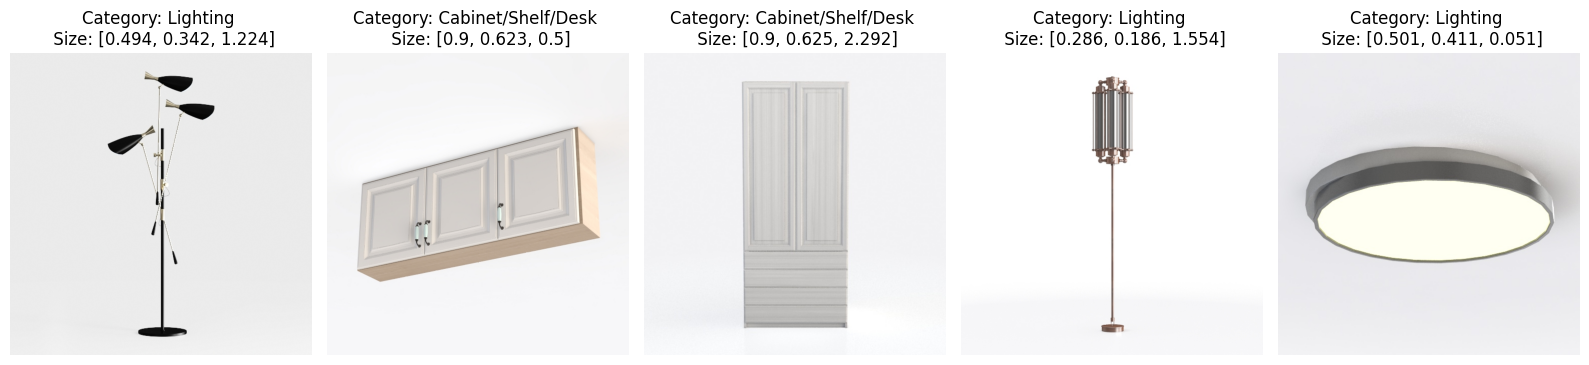

: 

In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
output_model_path = "furniture_size_regressor.pth"

# 모델 로드

loaded_model = FurnitureSizeRegressor(1048576, 8)
loaded_model.load_state_dict(torch.load(output_model_path, map_location=device))
loaded_model.eval()

# 테스트할 가구 이미지 시각화
furniture_data_sample = furniture_data[:5]
hundred_furniture_data_sample = furniture_data[:100]
import matplotlib.pyplot as plt
def visualize_furniture_images(img_paths, titles=None):
    plt.figure(figsize=(16, 16))
    for i, img_path in enumerate(img_paths):
        img = plt.imread(img_path)
        plt.subplot(4, 5, i + 1)
        plt.imshow(img)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("furniture_images_sample.pdf")
    plt.show()

sample_paths = [make_img_path(item['jid']) for item in furniture_data_sample]
hundred_sample_paths = [make_img_path(item['jid']) for item in hundred_furniture_data_sample]

visualize_furniture_images(sample_paths, titles=[f"Category: {item['category']} \n Size: {[round(s,3) for s in item['size']]}" for item in furniture_data_sample])



In [12]:
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch

caption_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
caption_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [13]:


# img = Image.open("your_image.jpg").convert("RGB")
imgs = [Image.open(path).convert("RGB") for path in hundred_sample_paths]
caption_list = []
for img in imgs:
    inputs = caption_processor(img, return_tensors="pt").to(device)
    out = caption_model.generate(**inputs)
    caption_list.append(caption_processor.decode(out[0], skip_special_tokens=True))


In [14]:
from tqdm import tqdm
from shap_e.diffusion.sample import sample_latents
from shap_e.models.download import load_model, load_config
from shap_e.diffusion.gaussian_diffusion import diffusion_from_config

batch_size = 4
guidance_scale = 15.0
caption_batches = [caption_list[i:i + batch_size] for i in range(0, len(caption_list), batch_size)]

latent_vectors = []


model = load_model('text300M', device=device)
diffusion = diffusion_from_config(load_config('diffusion'))
for batch in tqdm(caption_batches, desc="Processing batches", unit="batch"):
    latents = sample_latents(
        batch_size=batch_size,
        model=model,
        diffusion=diffusion,
        guidance_scale=guidance_scale,
        model_kwargs=dict(texts=batch),
        progress=True,
        clip_denoised=True,
        use_fp16=True,
        use_karras=True,
        karras_steps=64,
        sigma_min=1e-3,
        sigma_max=160,
        s_churn=0,
    )
    latent_vectors.extend(latents.cpu().numpy())

/home/eden/Documents/JNU/2025-1/AI-System/AI-System-Project/shap-e/shap_e/models/nn/checkpoint.py:31: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/eden/Documents/JNU/2025-1/AI-System/AI-System-Project/shap-e/shap_e/models/nn/checkpoint.py:43: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd
/home/eden/Documents/JNU/2025-1/AI-System/AI-System-Project/shap-e/shap_e/models/nn/checkpoint.py:61: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd
/home/eden/Documents/JNU/2025-1/AI-System/AI-System-Project/shap-e/shap_e/models/nn/checkpoint.py:86: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` ins

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:   4%|▍         | 1/25 [00:51<20:47, 51.97s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:   8%|▊         | 2/25 [01:42<19:35, 51.10s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  12%|█▏        | 3/25 [02:32<18:28, 50.40s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  16%|█▌        | 4/25 [03:21<17:32, 50.10s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  20%|██        | 5/25 [04:11<16:39, 49.96s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  24%|██▍       | 6/25 [05:01<15:47, 49.86s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  28%|██▊       | 7/25 [05:50<14:56, 49.80s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  32%|███▏      | 8/25 [06:40<14:05, 49.76s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  36%|███▌      | 9/25 [07:30<13:15, 49.73s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  40%|████      | 10/25 [08:20<12:29, 49.99s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  44%|████▍     | 11/25 [09:11<11:42, 50.16s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  48%|████▊     | 12/25 [10:01<10:52, 50.18s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  52%|█████▏    | 13/25 [10:51<10:02, 50.23s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  56%|█████▌    | 14/25 [11:41<09:12, 50.21s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  60%|██████    | 15/25 [12:32<08:24, 50.44s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  64%|██████▍   | 16/25 [13:23<07:35, 50.57s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  68%|██████▊   | 17/25 [14:14<06:44, 50.60s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  72%|███████▏  | 18/25 [15:04<05:53, 50.54s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  76%|███████▌  | 19/25 [15:55<05:02, 50.45s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  80%|████████  | 20/25 [16:45<04:12, 50.49s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  84%|████████▍ | 21/25 [17:36<03:21, 50.48s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  88%|████████▊ | 22/25 [18:25<02:30, 50.24s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  92%|█████████▏| 23/25 [19:15<01:40, 50.07s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches:  96%|█████████▌| 24/25 [20:05<00:49, 49.95s/batch]

  0%|          | 0/64 [00:00<?, ?it/s]

Processing batches: 100%|██████████| 25/25 [20:54<00:00, 50.19s/batch]


In [18]:
from torch.utils.data import Dataset, DataLoader

class FurnitureDataset(Dataset):
    def __init__(self, latent_vectors, class_indices, sizes):
        self.latents = torch.from_numpy(np.array(latent_vectors)).float()
        self.classes = torch.from_numpy(np.array(class_indices)).int()
        self.sizes = torch.from_numpy(np.array(sizes)).float()

    def __len__(self):
        return len(self.latents)

    def __getitem__(self, idx):
        return self.latents[idx], self.classes[idx], self.sizes[idx]

In [21]:
import wandb

test_class_indices = [one_hot_indices[i] for i in range(len(latent_vectors))]

test_sizes = [normalized_size_list[i] for i in range(len(latent_vectors))]

test_dataset = FurnitureDataset(latent_vectors, test_class_indices, test_sizes)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
print(f"Test dataset size: {len(test_dataloader)}")



Test dataset size: 7


In [22]:

criterion = nn.MSELoss()

loaded_model = loaded_model.to(device)
loaded_model.eval()

latent_dim = latent_vectors[0].shape[0]  # latent vector의 차원
class_count = len(category_set)

test_bar = tqdm(test_dataloader, total=len(test_dataloader), desc="Testing", unit="batch")
wandb.init(project="ai-system", name="furniture_size_regression_test", config={
    "latent_dim": latent_dim,
    "class_count": class_count,
    "batch_size": 32,
    "epochs": 10,
    "learning_rate": 1e-3
    })

with torch.no_grad():
    total_test_loss = 0.0
    for latents, classes, sizes in test_bar:
        latents, classes, sizes = latents.to(device), classes.to(device), sizes.to(device)
        outputs = loaded_model(latents, classes)
        loss = criterion(outputs, sizes)
        total_test_loss += loss.item()
        wandb.log({"test_loss": loss.item()})

    avg_test_loss = total_test_loss / len(test_dataloader)
    print(f"Test Loss: {avg_test_loss:.4f}")

Testing:   0%|          | 0/7 [00:00<?, ?batch/s]

Testing: 100%|██████████| 7/7 [00:02<00:00,  3.20batch/s]

Test Loss: 0.0097
